In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert  # para la envolvente

Parámetros sacados del paper

In [3]:
# Parameters
fs = 1e9  # Sampling frequency: 1 GHz
duration = 2e-6  # 2 microseconds
t = np.linspace(0, duration, int(fs * duration))

# Echo signal parameters (matching paper values)
echo_params = [
    {'A': 10, 'alpha': 300e12, 'f': 100e6, 'tau': 0.4e-6},
    {'A': 8, 'alpha': 300e12, 'f': 100e6, 'tau': 0.6e-6}
]

In [ ]:
def generate_echo(t, A, alpha, f, tau):
    return A * np.exp(-alpha * (t - tau)**2) * np.cos(2 * np.pi * f * (t - tau))

# Add noise with desired SNR
def add_noise(signal, snr_db):
    signal_power = np.mean(signal**2)
    snr_linear = 10**(snr_db / 10)
    noise_power = signal_power / snr_linear
    noise = np.random.normal(0, np.sqrt(noise_power), size=signal.shape)
    return signal + noise


In [ ]:
clean_signal = sum(generate_echo(t, **p) for p in echo_params)

snrs = [25, 15, 5]
noisy_signals = [add_noise(clean_signal, snr) for snr in snrs]

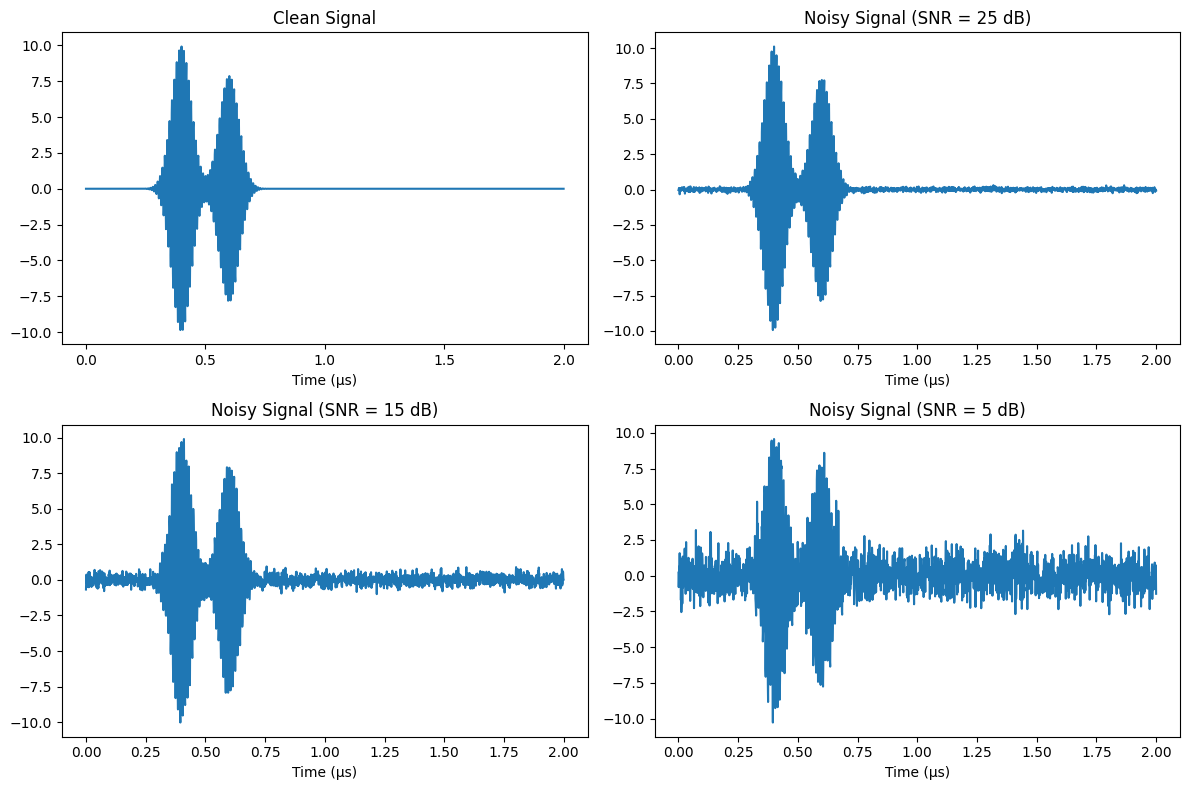

In [5]:
# Plotting
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(t * 1e6, clean_signal)
plt.title("Clean Signal")
plt.xlabel("Time (μs)")
plt.xticks(np.linspace(0, duration, 5) * 1e6)

for i, snr in enumerate(snrs):
    plt.subplot(2, 2, i+2)
    plt.plot(t * 1e6, noisy_signals[i])
    plt.title(f"Noisy Signal (SNR = {snr} dB)")
    plt.xlabel("Time (μs)")

plt.tight_layout()
plt.show()

Hacemos escaneo 2D de la oblea

In [ ]:
# Definimos el tamaño del escaneo
Nx, Ny = 100, 100
pixel_size = 0.1e-3  # 0.1 mm por píxel

# Creamos un “mapa de profundidad” de la oblea
depth_map = np.zeros((Nx, Ny))
for i in range(Nx):
    for j in range(Ny):
        # Si estamos en una ranura (digamos j entre 30 y 50)
        if i % 4 == 0:
            depth_map[i, j] = 0.15e-3  # 150 μm
        else:
            depth_map[i, j] = 0.5e-3   # resto de la oblea


In [11]:
cscan = np.zeros((Nx, Ny))

for i in range(Nx):
    for j in range(Ny):
        # Ajustamos tiempo de llegada según la profundidad local
        local_tau = depth_map[i, j] / 1500  # v ~1500 m/s
        params = [
            {**echo_params[0], 'tau': local_tau},
            {**echo_params[1], 'tau': local_tau + 0.2e-6}
        ]
        # Generamos la señal limpia
        clean = sum(generate_echo(t, **p) for p in params)
        # Añadimos ruido (ej. SNR 10 dB)
        noisy = add_noise(clean, snr_db=120) # Por ahora, SNR muy alto

        # TODO: Implementar el procesamiento de la señal (sacarle el ruido)

        # 1) Extraemos la envolvente con Hilbert
        env = np.abs(hilbert(noisy))
        # 2) Tomamos el valor pico de la envolvente
        cscan[i, j] = np.max(env)

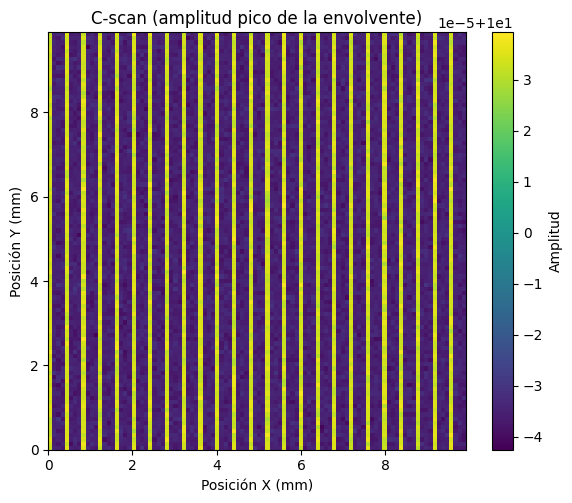

In [13]:

# Para visualizar en escala real
x = np.arange(Nx) * pixel_size * 1e3  # en mm
y = np.arange(Ny) * pixel_size * 1e3  # en mm

plt.figure(figsize=(6,5))
plt.imshow(cscan.T, 
           extent=[x.min(), x.max(), y.min(), y.max()],
           origin='lower')
plt.xlabel('Posición X (mm)')
plt.ylabel('Posición Y (mm)')
plt.title('C-scan (amplitud pico de la envolvente)')
plt.colorbar(label='Amplitud')
plt.tight_layout()
plt.show()

Hacer script para dada una imagen, generar las señales con sus ruidos